# Part II: Model-based Regularization

We now want to solve the problem

$$ \min_{u} \frac{1}{2}\|Au - k\|^2 + \operatorname{TV}(u)$$

where $TV:?\to ?$ is defined as

Becaus hard solve this that

$$
\min_{u}
\Big[\max_{y} \langle Au - k_t, y  \rangle - \frac{1}{2} \|y\|^2 \big] +
\Big[
\max_{z} \langle \nabla u, z \rangle - \chi_{B^\infty_\lambda}(z)
\Big]
$$

Employing forward-backward splitting for $u,y,z$ yields the update

$$
\begin{align*}
y \gets \frac{1}{1+\sigma}y + \frac{\sigma}{1+\sigma}(Au  -k_t )\\
z \gets \operatorname{proj}_{B^\infty_\lambda}\left( z + \sigma\nabla u\right)\\
u^-\gets u\\
u\gets u - \tau (A^Ty - \operatorname{div}(z))
\end{align*}
$$

Additionally we perform an overrelaxation step for $u$, 

$$
u\gets 2 u - u^-.
$$

In [1]:
import skimage as ski
import numpy as np

num_theta = 150
dim = 150
noise_lvl = 0.01 * dim
phantom = ski.img_as_float(ski.data.shepp_logan_phantom())
phantom = ski.transform.resize(phantom, (dim, dim))
theta = np.linspace(0,180, endpoint = False, num=num_theta)
sinogram =  ski.transform.radon(phantom, theta)
sinogram += np.random.normal(0, noise_lvl, size=sinogram.shape)

In [2]:
from optimizer import pdhg, imgrad, imdiv
from optimizer import lifted_variable as lv

class Radon:
    def __call__(self, u):
        return ski.transform.radon(u, theta)*(np.pi/(2 * num_theta))
    
    def adjoint(self, k):
        return ski.transform.iradon(k, theta, filter_name=None)

class Grad:
    def __call__(self, u):
        return imgrad(u)

    def adjoint(self, p):
        return -imdiv(p)

class A:
    def __init__(self,):
        self.radon = Radon()
        self.grad = Grad()

    def __call__(self, u):
        return lv([self.radon(u), self.grad(u)])

    def adjoint(self, p):
        return self.radon.adjoint(p[0]) + self.grad.adjoint(p[1])


alpha = 1.0/(np.prod(phantom.shape[-2:]))
lamda = .5

if lamda > 0.:
    def prox_fconj(p, sigma):
        p_0 = alpha/(alpha + sigma) * p[0] - (sigma * alpha)/(alpha + sigma) * sinogram
        p_1 = lamda * p[1] / np.maximum(1, np.linalg.norm(p[1], axis=0)/lamda)[None,...] # projection on L-inf ball
        return lv([p_0, p_1])
else:
    def prox_fconj(p, sigma):
        p_0 = alpha/(alpha + sigma) * p[0] - (sigma * alpha)/(alpha + sigma) * sinogram
        p_1 = 0 * p[1]
        return lv([p_0, p_1])


def energy_fun(A, u):
    Au = A(u)
    return (alpha/2) * np.linalg.norm(Au[0] - sinogram)**2 + lamda * np.sum(np.abs(Au[1]))


x0 = ski.transform.iradon(sinogram, theta=theta)
#x0 = np.zeros_like(phantom)
y0 = A()(x0)

tau = 0.001
sigma = 0.01

n_iter = 200
#prox_fconj



opt = pdhg(x0=x0, y0=y0, K=A(), prox_fconj=prox_fconj, tau=tau, sigma=sigma, n_iter=n_iter, energy_fun = energy_fun)
res = opt.compute()

C:\Users\roithtim\AppData\Local\miniconda3\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Iteration 1, energy: 1896.1593690221434
Iteration 2, energy: 1893.1309309078183
Iteration 3, energy: 1891.5873332318629
Iteration 4, energy: 1890.7859634727495
Iteration 5, energy: 1890.3555086722786
Iteration 6, energy: 1890.1105031627715
Iteration 7, energy: 1889.9582146657665
Iteration 8, energy: 1889.8522844958156
Iteration 9, energy: 1889.7695362885731
Iteration 10, energy: 1889.698382844006
Iteration 11, energy: 1889.6330262077408
Iteration 12, energy: 1889.5705693415684
Iteration 13, energy: 1889.5095637880665
Iteration 14, energy: 1889.4492859847812
Iteration 15, energy: 1889.3893730377886
Iteration 16, energy: 1889.3296447070575
Iteration 17, energy: 1889.2700158640885
Iteration 18, energy: 1889.2104350122386
Iteration 19, energy: 1889.150879521219
Iteration 20, energy: 1889.0913408544611
Iteration 21, energy: 1889.0318114476438
Iteration 22, energy: 1888.9722875993878
Iteration 23, energy: 1888.9127678952573
Iteration 24, energy: 1888.8532519765045
Iteration 25, energy: 1888.

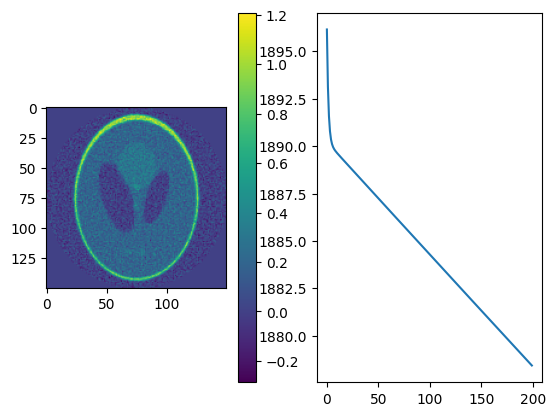

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
im = ax[0].imshow(opt.x)
plt.colorbar(im, ax=ax[0])
ax[1].plot(opt.energy_hist)

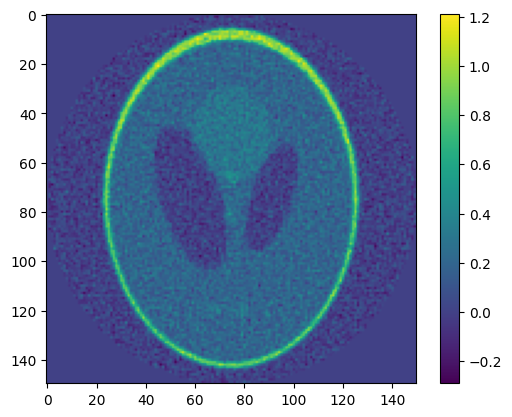

In [4]:
plt.imshow(x0)
plt.colorbar()

In [5]:
def test_adjoint(A, x, y=None):
    Ax = A(x)
    if y is None:
        y = np.random.uniform(size=Ax.shape)
    res_1 = np.sum(Ax * y)
    res_2 = np.sum(x * A.adjoint(y))
    return res_1, res_2


In [6]:
res_1, res_2 = test_adjoint(Grad(), phantom)

print(res_1)
print(res_2)
print((res_2/res_1))

1.0881148188052763
1.0881148188052785
1.000000000000002


In [7]:
A = np.random.uniform(size = (20,20))

class B:
    def __call__(self, x):
        return A@x

    def adjoint(self,y):
        return A.T@y

In [8]:
test_adjoint(B(), np.random.uniform(size=(20)))

(40.14648233600089, 40.14648233600088)

In [9]:
np.pi*np.sqrt(0.5)*3

6.664324407237549